# Task 1

The purpose of this task is to classify the demand for bikes on a specific day using predefined labels. The first stage of this will be to find appropriate values to use for the labels.

<a id='content'></a>
## Contents:
- [Preprocessing](#prep) - can skip running as data is reloaded at the start of the models
- [Models](#mods)

In [3]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.preprocessing import LabelEncoder

<a id='prep'></a>
## Preprocessing
[Back to contents](#content)

In [4]:
# Read in the data
train_data = pd.read_csv("./data/preprocessed_data/train.csv")

train_data

,latitude,longitude,distance_to_center,year,month,day,weekday,am_pm,isHoliday,isWeekend,mean_temperature,total_precipitation,stations_count,rides_count
0,45.523854,-73.519677,3.158849,2014,4,15,1,True,False,False,5.6,9.0,459,1
1,45.509310,-73.554431,0.051234,2014,4,15,1,True,False,False,5.6,9.0,459,2
2,45.511119,-73.567974,1.103429,2014,4,15,1,True,False,False,5.6,9.0,459,1
3,45.515330,-73.559148,0.814202,2014,4,15,1,True,False,False,5.6,9.0,459,4
4,45.514087,-73.552300,0.595784,2014,4,15,1,True,False,False,5.6,9.0,459,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
900167,45.534453,-73.559652,2.872826,2017,10,31,1,False,False,False,6.8,0.4,546,7
900168,45.500043,-73.560412,1.096697,2017,10,31,1,False,False,False,6.8,0.4,546,12
900169,45.504407,-73.572543,1.515227,2017,10,31,1,False,False,False,6.8,0.4,546,39
900170,45.491384,-73.586013,3.152155,2017,10,31,1,False,False,False,6.8,0.4,546,4


For the dataset for this task, we need data about the day, but not about individual stations. There should be one entry for each morning and afternoon, together with the weather data or other features for the whole day.

In [5]:
# Keeping the feature data for each day
day_data_cols = ['year', 'month', 'day', 'weekday', 'isHoliday', 'isWeekend', 'mean_temperature', 'total_precipitation']
day_data = train_data[day_data_cols].drop_duplicates(subset=day_data_cols, keep='first')

# Grouping the ride counts for each am and pm
train_new = train_data[['year', 'month', 'day', 'am_pm', 'rides_count']].groupby(['year', 'month', 'day', 'am_pm'], as_index=False)['rides_count'].sum()
train_new = train_new.merge(day_data, how='left', on=['year', 'month', 'day'])

train_new.head() #counts of the ride on a specific day (am/pm)

,year,month,day,am_pm,rides_count,weekday,isHoliday,isWeekend,mean_temperature,total_precipitation
0,2014,4,15,False,742,1,False,False,5.6,9.0
1,2014,4,15,True,835,1,False,False,5.6,9.0
2,2014,4,16,False,2462,2,False,False,-3.4,0.0
3,2014,4,16,True,718,2,False,False,-3.4,0.0
4,2014,4,17,False,4178,3,False,False,2.4,0.0


Now this data has been created, want to examine the distribution with some plots. This should give ideas for the labels to use for categories of ride counts.

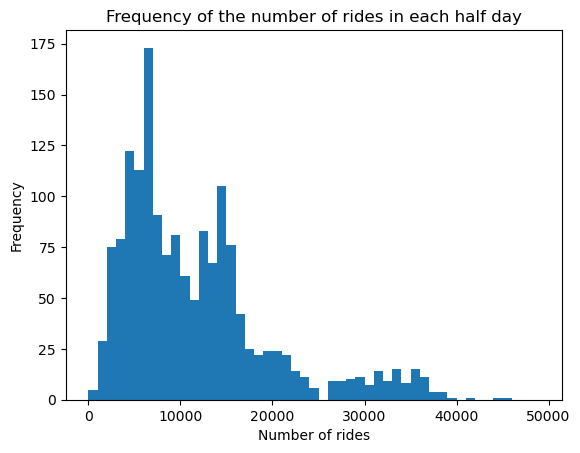

In [6]:
def dist_plot():
    plt.hist(train_new['rides_count'], bins=range(0,50000, 1000))

    plt.xlabel('Number of rides')
    plt.ylabel('Frequency')

dist_plot()
plt.title('Frequency of the number of rides in each half day')
plt.show()

It will be interesting to try different numbers of labels. For now, will create two versions. Three labels (low, medium and high) and five labels (very low, low, medium, high, very high). These will be implemented using numeric values for easier use later. These will be chosen by evenly dividing the data.

In [7]:
all_counts = list(train_new['rides_count'])
all_counts.sort()

# Thresholds for split into 3
label3_split = []
for i in range(1,3):
    label3 = all_counts[round(i*len(all_counts)/3)]
    label3_split.append(label3)


#Thresholds for split into 5
label5_split = []
for i in range(1,5):
    label5 = all_counts[round(i*len(all_counts)/5)]
    label5_split.append(label5)
    
print(label3_split, label5_split)

[6656, 13611] [5041, 7317, 12097, 16004]


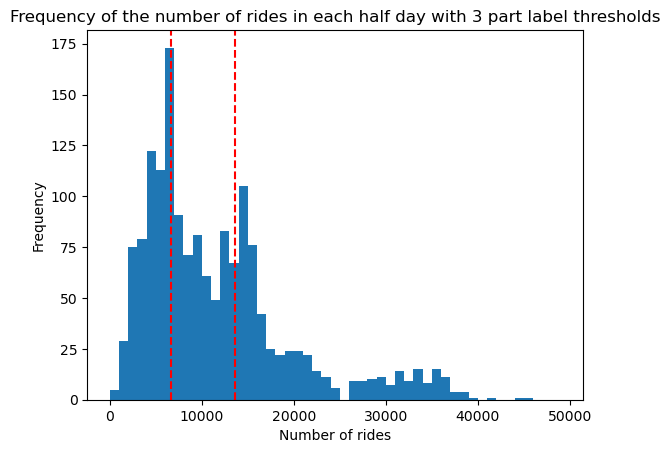

In [8]:
dist_plot()
for i in label3_split:
    plt.axvline(x=i, color='red', linestyle='dashed')
plt.title('Frequency of the number of rides in each half day with 3 part label thresholds')
plt.show()

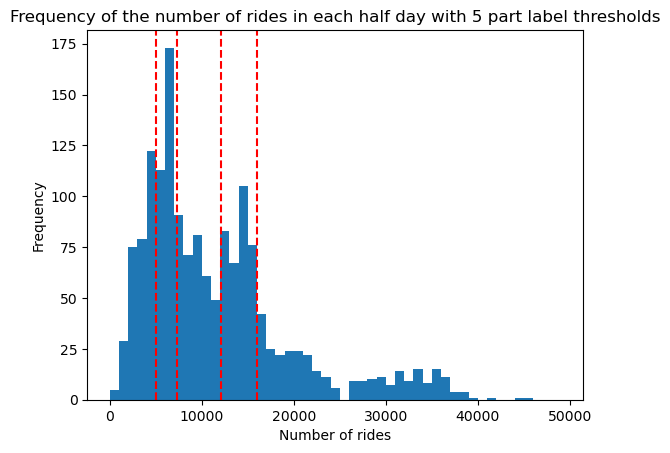

In [9]:
dist_plot()
for i in label5_split:
    plt.axvline(x=i, color='red', linestyle='dashed')
plt.title('Frequency of the number of rides in each half day with 5 part label thresholds')
plt.show()

The data table should now have values added in for these labels.

In [10]:
train_new['label3'] = np.select([train_new['rides_count']<label3_split[0],
                                 train_new['rides_count'].between(label3_split[0],label3_split[1])],
                                [1,2],3)
train_new['label5'] = np.select([train_new['rides_count']<label5_split[0],
                                 train_new['rides_count'].between(label5_split[0],label5_split[1]),
                                 train_new['rides_count'].between(label5_split[1],label5_split[2]),
                                 train_new['rides_count'].between(label5_split[2],label5_split[3])],
                                [1,2,3,4],5)

# train_new.head()

train3_target = train_new['label3']

train3_stringTarget = []

for i in train3_target:
    if i==1:
        train3_stringTarget.append("not busy")
    elif i == 2:
        train3_stringTarget.append("normal")
    else:
        train3_stringTarget.append("busy")
        
train3_target = pd.Series(train3_stringTarget)

train5_target = train_new['label5']

train5_stringTarget = []

for i in train5_target:
    if i==1:
        train5_stringTarget.append("not busy at all")
    elif i == 2:
        train5_stringTarget.append("not busy")
    elif i == 3:
        train5_stringTarget.append("normal")
    elif i == 4:
        train5_stringTarget.append("busy")
    else:
        train5_stringTarget.append("very busy")
        
train5_target = pd.Series(train5_stringTarget)

train_preprocessed = train_new.drop(columns=['label3','label5','rides_count','year','month','day'])

train_preprocessed.head()



,am_pm,weekday,isHoliday,isWeekend,mean_temperature,total_precipitation
0,False,1,False,False,5.6,9.0
1,True,1,False,False,5.6,9.0
2,False,2,False,False,-3.4,0.0
3,True,2,False,False,-3.4,0.0
4,False,3,False,False,2.4,0.0


In [11]:
dt3 = tree.DecisionTreeClassifier()
dt3.fit(train_preprocessed, train3_target)

dt5 = tree.DecisionTreeClassifier()
dt5.fit(train_preprocessed, train5_target)


DecisionTreeClassifier()

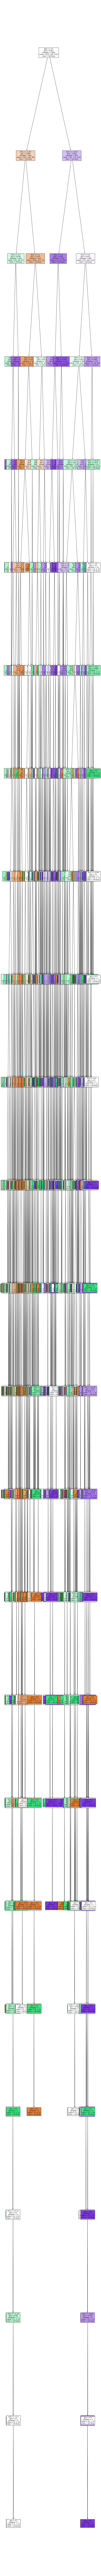

In [13]:
fig= plt.figure(figsize=(10,300))
_ = tree.plot_tree(dt3,  
                   class_names=train3_target,
                   filled=True, fontsize=10)
plt.show()


In [ ]:
fig = plt.figure(figsize=(10,20))
_ = tree.plot_tree(dt5,  
                   class_names=train5_target,
                   filled=True)

[Text(0.4, 0.8333333333333334, 'X[4] <= 6655.0\ngini = 0.667\nsamples = 1600\nvalue = [532, 535, 533]'),
 Text(0.2, 0.5, 'gini = 0.0\nsamples = 533\nvalue = [0, 0, 533]'),
 Text(0.6, 0.5, 'X[4] <= 13614.0\ngini = 0.5\nsamples = 1067\nvalue = [532, 535, 0]'),
 Text(0.4, 0.16666666666666666, 'gini = 0.0\nsamples = 535\nvalue = [0, 535, 0]'),
 Text(0.8, 0.16666666666666666, 'gini = 0.0\nsamples = 532\nvalue = [532, 0, 0]')]

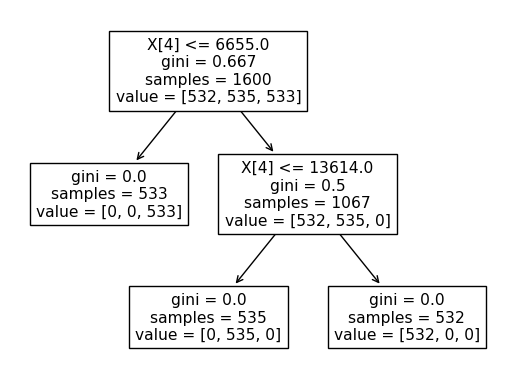

In [106]:
tree.plot_tree(dt3)

In [ ]:
tree.plot_tree(dt5)

Now need to carry out the same processing on the validation and test data and add the labels. Then both files can be saved.

In [93]:
valid_data = pd.read_csv("./data/preprocessed_data/valid.csv")

day_data = valid_data[day_data_cols].drop_duplicates(subset=day_data_cols, keep='first')
valid_new = valid_data[['year', 'month', 'day', 'am_pm', 'rides_count']].groupby(['year', 'month', 'day', 'am_pm'], as_index=False)['rides_count'].sum()
valid_new = valid_new.merge(day_data, how='left', on=['year', 'month', 'day'])

valid_new['label3'] = np.select([valid_new['rides_count']<label3_split[0],
                                 valid_new['rides_count'].between(label3_split[0],label3_split[1])],
                                [1,2],3)
valid_new['label5'] = np.select([valid_new['rides_count']<label5_split[0],
                                 valid_new['rides_count'].between(label5_split[0],label5_split[1]),
                                 valid_new['rides_count'].between(label5_split[1],label5_split[2]),
                                 valid_new['rides_count'].between(label5_split[2],label5_split[3])],
                                [1,2,3,4],5)

test_data = pd.read_csv("./data/preprocessed_data/test.csv")

day_data = test_data[day_data_cols].drop_duplicates(subset=day_data_cols, keep='first')
test_new = test_data[['year', 'month', 'day', 'am_pm', 'rides_count']].groupby(['year', 'month', 'day', 'am_pm'], as_index=False)['rides_count'].sum()
test_new = test_new.merge(day_data, how='left', on=['year', 'month', 'day'])

test_new['label3'] = np.select([test_new['rides_count']<label3_split[0],
                                 test_new['rides_count'].between(label3_split[0],label3_split[1])],
                                [1,2],3)
test_new['label5'] = np.select([test_new['rides_count']<label5_split[0],
                                 test_new['rides_count'].between(label5_split[0],label5_split[1]),
                                 test_new['rides_count'].between(label5_split[1],label5_split[2]),
                                 test_new['rides_count'].between(label5_split[2],label5_split[3])],
                                [1,2,3,4],5)

train_new.to_csv("data/preprocessed_data/t1_train.csv", index=False)
valid_new.to_csv("data/preprocessed_data/t1_valid.csv", index=False)
test_new.to_csv("data/preprocessed_data/t1_test.csv", index=False)

<a id='mods'></a>
## Models
[Back to contents](#content)

1. [KNN](#KNN)

First to read in the data, for if the earlier cells have not been run.

In [11]:
train_new = pd.read_csv("./data/preprocessed_data/t1_train.csv")
valid_new = pd.read_csv("./data/preprocessed_data/t1_valid.csv")
test_new = pd.read_csv("./data/preprocessed_data/t1_test.csv")

<a id='knn'></a>
### K-Nearest Neighbour
[Back to models](#mods)

For this model, can look later at the effect of converting the continuous variables to categorical variables. 

For now, all of the columns relating to the specific year and the number of rides need to be removed. Month is left in as a measure of the season in the year. Each of the label columns can be tested as the target variable. All of the Boolean variables should be converted to one hot encoding.

In [47]:
train_target_a = train_new['label3']
train_target_b = train_new['label5']
valid_target_a = valid_new['label3']
valid_target_b = valid_new['label5']
test_target_a = test_new['label3']
test_target_b = test_new['label5']

train_1 = train_new.drop(columns=['rides_count', 'label3', 'label5', 'year', 'day'])
valid_1 = valid_new.drop(columns=['rides_count', 'label3', 'label5', 'year', 'day'])
test_1 = test_new.drop(columns=['rides_count', 'label3', 'label5', 'year', 'day'])

Now the first models can be built.

In [45]:
# create the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', preprocessing.StandardScaler(), ['mean_temperature', 'total_precipitation']),
        ('encoder', preprocessing.OneHotEncoder(), ['am_pm', 'isHoliday', 'isWeekend', 'month']) ])

# choose the estimator and define a pipeline
estimator = KNeighborsClassifier(n_neighbors=15)
pipeline = Pipeline([ ('preprocessing', preprocessor), ('classification', estimator) ])

# cross validate the pipeline
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=33)
accuracy = cross_val_score(pipeline, train_1, train_target_a, cv=cv, scoring='accuracy')
accuracy2 = cross_val_score(pipeline, train_1, train_target_b, cv=cv, scoring='accuracy')
display(accuracy.mean(), accuracy2.mean())

0.63125

0.45875000000000005

In [48]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

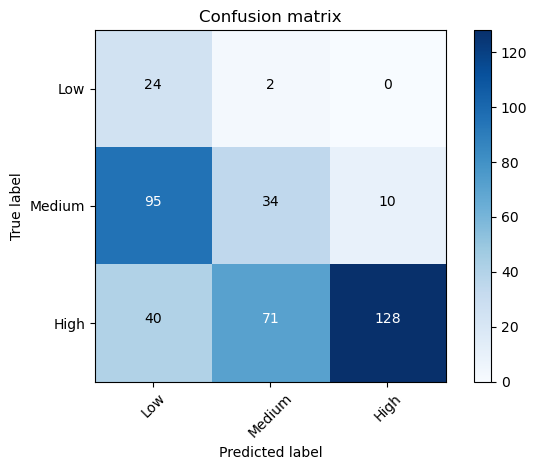

In [55]:
pipeline.fit(train_1, train_target_a)
test_predict = pipeline.predict(test_1)

cnf_matrix = confusion_matrix(test_target_a, test_predict)
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=['Low', 'Medium', 'High'])